# **Experiments on synthetic data**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lealagonotte/Geometric_data_analysis_project/blob/raph-colab/experiments/main_diet.ipynb)  
See on Hugging Face: https://huggingface.co/datasets/xingjiepan/PerturbMulti

## **Colab setup**

In [ ]:
!git clone https://github.com/lealagonotte/Geometric_data_analysis_project.git
%cd Geometric_data_analysis_project/
!git clone https://github.com/raphaelrubrice/Perturb-OT.git
!git checkout raph-colab

In [ ]:
!pip install -r requirements-env.txt

YOU WILL NEED TO RESTART THE SESSION AFTER THE PREVIOUS CELL.
After restarting you should have a working env.

Let's check that we have succesfully recreated the env

In [ ]:
import sys

import perturbot.match
import perturbot.predict
from perturbot.match import (
    get_coupling_cotl, 
    get_coupling_cotl_sinkhorn, 
    get_coupling_egw_labels_ott,
    get_coupling_egw_all_ott,
    get_coupling_eot_ott,
    get_coupling_leot_ott,
    get_coupling_egw_ott,
    get_coupling_cot, 
    get_coupling_cot_sinkhorn, 
    get_coupling_gw_labels,
    get_coupling_fot,
)
from perturbot.predict import train_mlp
from perturbot.eval.prediction import get_evals, get_evals_preds
from perturbot.eval.match import get_FOSCTTM_single, get_FOSCTTM
import ot
print("Imports succeeded")

## **Imports**

In [ ]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme("paper")
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from scanpy.preprocessing import subsample

import itertools, time, os
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold

## **Download the data**

In [ ]:
%cd Geometric_data_analysis_project/
!mkdir data
%cd data
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/RNA_scaled_diet_conditions_20240411.h5ad
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/protein_intensities_diet_conditions_20240411.h5ad

In [ ]:
%cd /content/Geometric_data_analysis_project/

## **Load & process data**

In [ ]:
path_rna_diet = "./data/RNA_scaled_diet_conditions_20240411.h5ad"
rna_diet = ad.read_h5ad(path_rna_diet)

In [ ]:
rna_diet.obs.head()

,fov,x,y,z,area,cond,batch
id,,,,,,,
100001368350601220443305171011375780801,717,6666.830785,7236.949846,0,296.588262,adlib,IE29
100001800432857001134785976606575060287,849,8413.609407,7209.004054,9,28.819318,adlib,IE29
100002804203690621291738422225750332629,659,6218.665741,3959.272899,6,47.580965,adlib,IE29
100003573867315829655028318295181964954,478,4796.646369,2362.160563,0,596.398900,adlib,IE29
100008668971788868972348129958710863790,885,8984.942123,4629.471220,3,31.794475,adlib,IE29


In [ ]:
path_prot_diet = "./data/protein_intensities_diet_conditions_20240411.h5ad"
prot_diet = ad.read_h5ad(path_prot_diet)

In [ ]:
prot_diet.obs.head()

,cell_id,condition,cell_name,fov,x,y,z,area,cond,batch,n_genes,n_counts,datatype,leiden,new_leiden,new_leiden_relabeled,cell_type,cluster_type,cell_type_color,cluster_type_color
0,0,adlib_T cell,92741088075053779116951994856866301126,631,10487.513193,125.414363,1,288.918642,adlib,2,79,409.0,merfish,16,2,5,T cell,T cell,8,15
1,1,adlib_T cell,133524280519918220907967806861786402321,847,8363.706168,6825.614590,0,342.417939,adlib,1,49,184.0,merfish,16,2,5,T cell,T cell,8,15
2,2,adlib_T cell,116603158813595984705504213443274415416,781,12026.084383,855.943716,4,52.808116,adlib,2,30,113.0,merfish,16,2,5,T cell,T cell,8,15
3,3,adlib_T cell,317866311329856700012086944685408447975,272,3096.611149,2092.912335,5,123.233572,adlib,1,63,292.0,merfish,16,2,5,T cell,T cell,8,15
4,4,adlib_T cell,150257798544309436723007524508073422512,654,6152.449135,7133.888484,0,96.995168,adlib,1,24,53.0,merfish,16,2,5,T cell,T cell,8,15


In [ ]:
GENES = list(rna_diet.var.index)
PROTEINS = list(prot_diet.var.index)
CONDITIONS = list(np.unique(rna_diet.obs['cond']))

In [ ]:
print(f"Number of Genes: {len(GENES)}")
print(f"Number of Proteins: {len(PROTEINS)}")
print(f"Number of conditions: {len(CONDITIONS)} ({CONDITIONS})")

Number of Genes: 260
Number of Proteins: 18
Number of conditions: 3 (['adlib', 'fasted', 'hfd'])


In [ ]:
print("Maximum expression", np.max(rna_diet.X))
print("Minimum expression", np.min(rna_diet.X))

Maximum expression 10.0
Minimum expression -0.7879467953842848


In [ ]:
print("Maximum intensity", np.max(prot_diet.X))
print("Minimum intensity", np.min(prot_diet.X))

Maximum intensity nan
Minimum intensity nan


In [ ]:
print("There are nans:", np.isnan(prot_diet.X).sum())

There are nans: 36


In [ ]:
nan_mask_rowise = np.where(np.isnan(prot_diet.X).sum(axis=1) > 0, True, False) 
print(f"These nans come from {nan_mask_rowise.sum()} rows")
prot_diet.X[nan_mask_rowise,:]

These nans come from 2 rows


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]])

Let's remove these rows

In [ ]:
prot_diet_noNA = prot_diet[~nan_mask_rowise,:]
print("Maximum intensity", np.max(prot_diet_noNA.X))
print("Minimum intensity", np.min(prot_diet_noNA.X))

Maximum intensity 0.8667076230049133
Minimum intensity 0.004974730312824249


In [ ]:
prot_diet.obs["cond"].value_counts() / prot_diet.shape[0]

cond
adlib     0.352573
fasted    0.329616
hfd       0.317811
Name: count, dtype: float64

In [ ]:
rna_diet.obs["cond"].value_counts() / rna_diet.shape[0]

cond
adlib     0.364393
fasted    0.322702
hfd       0.312905
Name: count, dtype: float64

All three diets are quite well balanced in the dataset.  
For the remaining cells we will use a subset of the data where only a fraction of cells of each conditions are used for speed purposes.

In [ ]:
def condition_subsample(adata, frac, cond_col):
    all_conditions = np.unique(adata.obs[cond_col])
    adata_list = []
    for cond in all_conditions:
        cond_adata = adata[adata.obs[cond_col] == cond]
        adata_list.append(subsample(cond_adata,frac,copy=True))
    return ad.concat(adata_list, axis=0)

FRAC = 0.01

In [ ]:
sub_rna_diet = condition_subsample(rna_diet, FRAC, 'cond')
sub_rna_diet

AnnData object with n_obs × n_vars = 738 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'

In [ ]:
sub_prot_diet = condition_subsample(prot_diet, FRAC, 'cond')
sub_prot_diet

AnnData object with n_obs × n_vars = 500 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'

We can check that condition proportions are respected

In [ ]:
sub_rna_diet.obs['cond'].value_counts() / sub_rna_diet.shape[0]

cond
adlib     0.364499
fasted    0.322493
hfd       0.313008
Name: count, dtype: float64

In [ ]:
sub_prot_diet.obs['cond'].value_counts() / sub_prot_diet.shape[0]

cond
adlib     0.352
fasted    0.330
hfd       0.318
Name: count, dtype: float64

## **Visualize data**

Great, now let's visualize our data with UMAP

In [ ]:
def pca_data(adata):
    # Computing reduced dimension
    print("Reducing dimension..")
    sc.tl.pca(adata)
    print("Plotting PCA Variance ratios..")
    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False)

def plot_umap(adata, cond_col, 
              reduce_data=True, 
              n_neighbors=15, 
              metric='euclidean', 
              min_dist=0.1, 
              spread=1.0,
              addon=''):
    if reduce_data:
        pca_data(adata)
    # Obtain neighbors
    print("Obtaining neighbors..")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric=metric)
    # Compute umap
    print("Computing UMAP..")
    sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    # Plot
    print("Plotting..")
    sc.pl.umap(adata, 
               color=cond_col, 
               title=f"Dataset ({addon} modality) colored by diet condition", 
               save=f"Our_UMAP_Diet_{addon}.pdf")

Reducing dimension..
Plotting PCA Variance ratios..


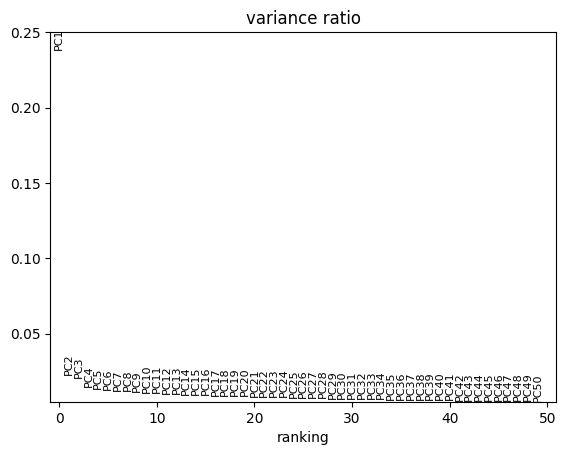

Obtaining neighbors..


/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Computing UMAP..
Plotting..


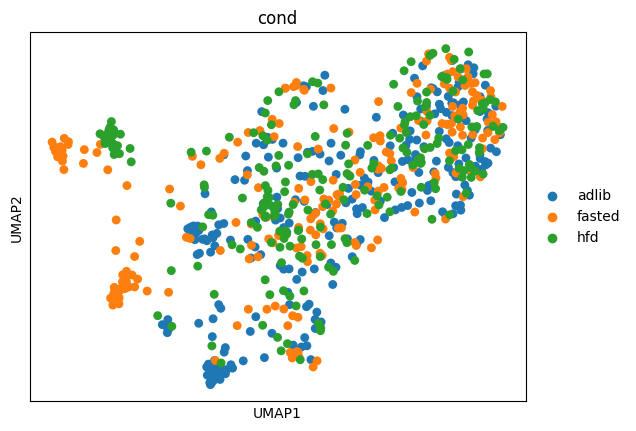

In [ ]:
plot_umap(sub_rna_diet, 'cond', 
          reduce_data=True, 
          n_neighbors=15, 
          metric='euclidean', 
          min_dist=0.1, 
          spread=1.0,
          addon='RNA')

In [ ]:
sub_rna_diet

AnnData object with n_obs × n_vars = 738 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'
    uns: 'pca', 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Obtaining neighbors..


Computing UMAP..
Plotting..


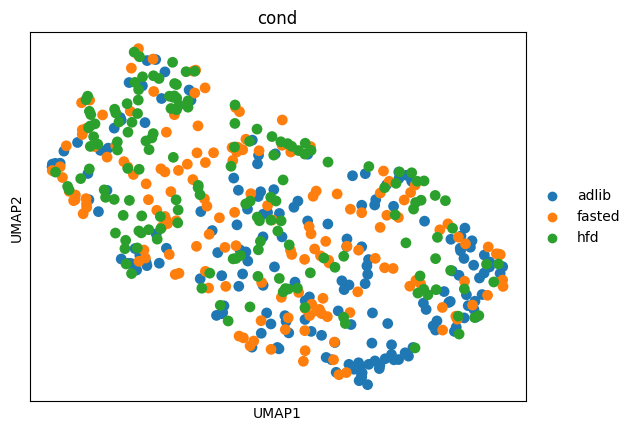

In [ ]:
plot_umap(sub_prot_diet, 'cond', 
          reduce_data=False, 
          n_neighbors=15, 
          metric='euclidean', 
          min_dist=0.1, 
          spread=1.0,
          addon='PROTEIN')

In [ ]:
sub_prot_diet

AnnData object with n_obs × n_vars = 500 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'
    uns: 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

We clearly do not have a UMAP space as good as the authors, we need to find better UMAP hyperparameters in hope of identifying a good combination to visualize our data.

In [ ]:
def grid_search_umap(adata):
    n_neighbors_list = [15, 50, 100]
    min_dist_list = [0.01, 0.1, 0.3, 0.5]
    spread_list = [0.5, 1.0, 1.5, 10]
    metrics = ['euclidean']

    # Create all combinations
    param_grid = list(itertools.product(n_neighbors_list, min_dist_list, spread_list, metrics))

    # Run grid search
    for i, (n_neighbors, min_dist, spread, metric) in tqdm(enumerate(param_grid), total=len(param_grid)):
        print(f"Running UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}, metric={metric}")
    
        try:
            plot_umap(
                sub_rna_diet,
                'cond',
                reduce_data=False,
                n_neighbors=n_neighbors,
                metric=metric,
                min_dist=min_dist,
                spread=spread
            )
        except Exception as e:
            print(f"Failed with: {e}")

I ran it, it took about 30 min on my device but it revealed that none of the proposed combinations really helped. I suspect that the apparent structure at ~5k cells could be much different than that with the whole dataset.

In [ ]:
# grid_search_umap(sub_rna_diet)

In [ ]:
# grid_search_umap(sub_prot_diet)

## **Cross-Validation splits**

In [ ]:
def create_stratified_folds(
    adata: ad.AnnData,
    n_splits: int = 5,
    label_key: str = "cond",
    random_state: int = 1234,
):
    """
    Create stratified CV folds for a single AnnData object.

    Parameters
    ----------
    adata : AnnData
        AnnData object to split.
    n_splits : int
        Number of CV folds.
    label_key : str
        Column in .obs used for stratification (e.g. "cond").
    random_state : int
        Random seed for reproducible splits.

    Returns
    -------
    folds : list of dict
        Each dict contains:
        - "fold": int
        - "train_idx": np.ndarray
        - "test_idx": np.ndarray
    """
    labels = np.array(adata.obs[label_key])
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state,
    )

    folds = []
    for fold_id, (train_idx, test_idx) in enumerate(skf.split(adata.X, labels)):
        folds.append(
            {
                "fold": fold_id,
                "train_idx": train_idx,
                "test_idx": test_idx,
            }
        )

    return folds

def run_coupling_cv(
    adata_rna: ad.AnnData,
    adata_prot: ad.AnnData,
    rna_folds,
    prot_folds,
    conditions,
    coupling_func,
    pca_key: str = "X_pca",
    label_key: str = "cond",
    coupling_kwargs: dict | None = None,
):
    """
    Run a coupling function across CV folds for UNALIGNED RNA & PROT.

    Fold k of RNA is paired with fold k of PROT (no cell-wise alignment).
    Only the training splits are used to construct the coupling.
    """
    if coupling_kwargs is None:
        coupling_kwargs = {}

    if len(rna_folds) != len(prot_folds):
        raise ValueError("rna_folds and prot_folds must have the same length (same n_splits).")

    couplings = []

    n_folds = len(rna_folds)
    for k in range(n_folds):
        rna_fold = rna_folds[k]
        prot_fold = prot_folds[k]

        rna_train_idx = rna_fold["train_idx"]
        prot_train_idx = prot_fold["train_idx"]

        # subset TRAIN data
        train_adata_RNA = adata_rna[rna_train_idx].copy()
        train_RNA_labels = np.array(train_adata_RNA.obs['cond'])
        train_adata_PROT = adata_prot[prot_train_idx].copy()
        train_PROT_labels = np.array(train_adata_PROT.obs['cond'])

        # Build train dictionaries per condition
        train_RNA_reduced = {
            i: train_adata_RNA[train_adata_RNA.obs[label_key] == cond].obsm[pca_key]
            for i, cond in enumerate(conditions)
        }
        train_PROT = {
            i: train_adata_PROT[train_adata_PROT.obs[label_key] == cond].X
            for i, cond in enumerate(conditions)
        }

        data_train = (train_RNA_reduced, train_PROT)

        # Call the coupling function on this fold's train data
        if coupling_func.__name__ == "get_coupling_fused_gw":
            # Call the FGW function with X, Y, labels
            coupling = coupling_func(
                train_adata_RNA.X,
                train_adata_PROT.X,
                train_RNA_labels,
                train_PROT_labels,
                **coupling_kwargs,
            )
        else:
            coupling = coupling_func(
                data_train,
                **coupling_kwargs,
            )

        couplings.append(coupling)

    return couplings


In [ ]:
rna_folds = create_stratified_folds(
    sub_rna_diet,
    n_splits=5,
    label_key="cond",
    random_state=1234,
)

prot_folds = create_stratified_folds(
    sub_prot_diet,
    n_splits=5,
    label_key="cond",
    random_state=1234,
)

In [ ]:
def compute_metrics(
    coupling_list,
    method_name,
    *,
    rna_folds,
    prot_folds,
    sub_rna_diet,
    sub_prot_diet,
    labels,
):
    """
    Compute metrics over CV for one OT method.
    """
    n_folds = len(rna_folds)
    per_fold_metrics = []

    print(f"\n=== Running CV for method: {method_name} ===")

    for k in range(n_folds):
        print(f"\n--- Fold {k+1}/{n_folds} ---")

        # Indices for this fold
        rna_train_idx = rna_folds[k]["train_idx"]
        rna_test_idx  = rna_folds[k]["test_idx"]
        prot_train_idx = prot_folds[k]["train_idx"]
        prot_test_idx  = prot_folds[k]["test_idx"]

        # Subset AnnData
        train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
        test_adata_RNA   = sub_rna_diet[rna_test_idx].copy()
        train_adata_PROT = sub_prot_diet[prot_train_idx].copy()
        test_adata_PROT  = sub_prot_diet[prot_test_idx].copy()

        # Build training dicts
        train_RNA_reduced = {
            i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"]
            for i, cond in enumerate(labels)
        }
        train_PROT = {
            i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X
            for i, cond in enumerate(labels)
        }
        data_train = (train_RNA_reduced, train_PROT)

        # Test input (PROT)
        X_test = test_adata_PROT.X.astype(np.float32)
        X_test_t = torch.from_numpy(X_test)

        # Ground truth (RNA)
        Y_test_concatenated = test_adata_RNA.X.astype(np.float64)

        # Coupling & time for this fold and method
        coupling_for_train, time_for_train = coupling_list[k]

        # Train MLP
        model, pred_log = perturbot.predict.train_mlp(data_train, coupling_for_train)

        # Predict
        model.eval()
        with torch.no_grad():
            Y_pred = model(X_test_t).cpu().numpy().astype(np.float64)

        # Metrics for this fold (column name is method_name)
        metrics_df_pred = get_evals_preds(
            Y_test_concatenated,
            [Y_pred],
            pred_labels=[method_name],
            full=False,
        )
        metrics_series = metrics_df_pred[method_name]

        # Store fold metrics as dict
        metrics_dict = metrics_series.to_dict()
        metrics_dict["time"] = time_for_train
        metrics_dict["fold"] = k
        per_fold_metrics.append(metrics_dict)

        print(
            f"{method_name} | fold {k}: "
            f"MSE={metrics_dict.get('MSE', np.nan):.4f}, "
            f"Pearson={metrics_dict.get('Pearson_corr', np.nan):.4f}"
        )

    # All folds for this method
    per_fold_df = pd.DataFrame(per_fold_metrics)

    # Aggregate numeric metrics across folds (mean); you can extend with std if desired
    numeric_cols = per_fold_df.select_dtypes(include=[np.number]).columns
    mean_row = per_fold_df[numeric_cols].mean().to_frame().T  # 1-row DataFrame
    std_row = per_fold_df[numeric_cols].std().to_frame().T

    # Add method name (and anything else you want to keep as metadata)
    mean_row["method"] = method_name
    std_row["method"] = method_name

    return mean_row, std_row # 1-row DataFrames

def compute_match_metrics(
    coupling_list,
    method_name,
    *,
    rna_folds,
    prot_folds,
    sub_rna_diet,
    sub_prot_diet,
    labels,
    labeled: bool,
):
    """
    Compute coupling matching metrics (FOSCTTM) for ONE method across all folds.
    """
    n_folds = len(rna_folds)
    per_fold_metrics = []

    print(f"\n=== Running match metrics for method: {method_name} ===")

    for k in range(n_folds):
        print(f"\n--- Fold {k+1}/{n_folds} ---")
        print("Evaluation of coupling metrics on the training data")

        # -----------------------------
        # 1. Build train data dicts for this fold
        # -----------------------------
        rna_train_idx = rna_folds[k]["train_idx"]
        prot_train_idx = prot_folds[k]["train_idx"]

        train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
        train_adata_PROT = sub_prot_diet[prot_train_idx].copy()

        Xs_train_dict = {
            i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"]
            for i, cond in enumerate(labels)
        }
        Xt_train_dict = {
            i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X
            for i, cond in enumerate(labels)
        }

        # -----------------------------
        # 2. Compute FOSCTTM depending on type
        # -----------------------------
        if labeled:
            # coupling_list[k] = (T_dict, info)
            T_dict, info = coupling_list[k]

            foscttm_bary_list, median_foscttm_bary = get_FOSCTTM(
                T_dict=T_dict,
                Xs_dict=Xs_train_dict,
                Xt_dict=Xt_train_dict,
                use_barycenter=True,
            )
        else:
            # coupling_list[k] = (T, info)
            T, info = coupling_list[k]

            foscttm_bary_list, median_foscttm_bary = get_FOSCTTM_single(
                T=T,
                Xs_dict=Xs_train_dict,
                Xt_dict=Xt_train_dict,
                use_barycenter=True,
            )

        all_foscttm_bary = foscttm_bary_list
        mean_foscttm_bary = np.nanmean(all_foscttm_bary)

        metrics_dict = {
            "fold": k,
            "method": method_name,
            "Bary_FOSCTTM": median_foscttm_bary,
            "Mean_Bary_FOSCTTM": mean_foscttm_bary,
        }

        # If `info` is a scalar time or something similar, you can optionally store it:
        if np.isscalar(info):
            metrics_dict["time"] = info

        per_fold_metrics.append(metrics_dict)

        print(
            f"{method_name} | fold {k}: "
            f"Bary_FOSCTTM={median_foscttm_bary:.4f}, "
            f"Mean_Bary_FOSCTTM={mean_foscttm_bary:.4f}"
        )

    # -----------------------------
    # Aggregate across folds into 1 row
    # -----------------------------
    per_fold_df = pd.DataFrame(per_fold_metrics)

    numeric_cols = per_fold_df.select_dtypes(include=[np.number]).columns
    mean_row = per_fold_df[numeric_cols].mean().to_frame().T  # 1-row
    std_row = per_fold_df[numeric_cols].std().to_frame().T

    # add method name (and labeled/global flag if you like)
    mean_row["method"] = method_name
    mean_row["labeled"] = labeled
    std_row["method"] = method_name
    std_row["labeled"] = labeled

    return mean_row, std_row


In [ ]:
mean_results_list = []
std_results_list = []
mean_match_results_list = []
std_match_results_list = []

## **Compute couplings with diverse methods**
(GWOT, COOT, FGWOT, with or without labels, with or without entropic regularization)

In [ ]:
coupling_names = [
    "EGWOT Labeled (legw)", 
    "EGWOT All (egw)", 
    "EGWOT Per Label (egwper)", 
    "COOT Labeled (cotl)", 
    "ECOOT Labeled (ecotl)", 
    "COOT All (cot)", 
    "ECOOT All (ecot)",
    "Fused GW (fgw)",
]

In [ ]:
#EGWOT labeled
legw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_labels_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.001},
                            )

In [ ]:
results = compute_metrics(legw,
                "EGWOT Labeled (legw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(legw,
                "EGWOT Labeled (legw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

In [ ]:
#EGWOT without labels
egw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_all_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.005},
                            )

In [ ]:
results = compute_metrics(egw,
                "EGWOT All (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(egw,
                "EGWOT All (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

In [ ]:
#EGWOT per labels
egwper = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.05},
                            )

In [ ]:
results = compute_metrics(egwper,
                "EGWOT Per Label (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(egwper,
                "EGWOT Per Label (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

In [ ]:
#COOT labeled
cotl = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cotl,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={},
                            )

In [ ]:
results = compute_metrics(cotl,
                "COOT Labeled (cotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(cotl,
                "COOT Labeled (cotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

In [ ]:
#ECOOT labeled
ecotl = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cotl,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps":0.5},
                            )

In [ ]:
results = compute_metrics(ecotl,
                "ECOOT Labeled (ecotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(ecotl,
                "ECOOT Labeled (ecotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

In [ ]:
#COOT without labels
cot = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cot,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={},
                            )

In [ ]:
results = compute_metrics(cot,
                "COOT All (cot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(cot,
                "COOT All (cot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

In [ ]:
#ECOOT without labels
ecot = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cot_sinkhorn,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps":0.5},
                            )

In [ ]:
results = compute_metrics(cot,
                "ECOOT All (ecot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(cot,
                "ECOOT All (ecot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

In [ ]:
#Fused GW
def get_coupling_fused_gw(X_train, Y_train, labels_X, labels_Y, epsilon=0.001, alpha=0.99, max_iter=500):
    """
    Compute the Fused Gromov-Wasserstein coupling between X_train and Y_train
    using labels_train for the fused cost.
    """
    # -----------------------------
    # 1. Matrices de coût C1 et C2
    # -----------------------------
    # Calcul des matrices de coût quadratiques normalisées
    C1 = ot.dist(X_train, X_train, metric='euclidean')**2
    C2 = ot.dist(Y_train, Y_train, metric='euclidean')**2
    C1=C1/C1.max()
    C2=C2/C2.max()

    # -----------------------------
    # 2. Matrice de coût fused M
    # -----------------------------
    # Ici M[i,j] = 1 si labels différents, 0 sinon
    start = time.time()
    n_train = X_train.shape[0]
    m_train = Y_train.shape[0]

    # M = 1 si labels différents
    M = (labels_X[:, None] != labels_Y[None, :]).astype(float)

    print("Calcul du transport plan Fused Gromov-Wasserstein (alpha=1 -> GW uniquement)...")
    T = ot.gromov.entropic_fused_gromov_wasserstein(
        M, C1, C2, alpha=alpha, epsilon=epsilon, max_iter=max_iter, verbose=True
    ) 
    end= time.time()
    runtime = end - start
    return T, {"time": runtime}

fgw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_fused_gw,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"epsilon":0.001, "alpha":0.99, "max_iter":500},
                            )

running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.291
Done running LEGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.010
Done running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating line

NameError: name 'time' is not defined

In [ ]:
results = compute_metrics(cot,
                "Fused GW (fgw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])

In [ ]:
results = compute_match_metrics(cot,
                "Fused GW (fgw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])

## **Train MLP to evaluate performances on obtained couplings**

In [ ]:
# couplings = [legw, egw, egwper, cotl, ecotl, cot, ecot, fgw]
# coupling_names = [
#     "EGWOT Labeled (legw)", 
#     "EGWOT All (egw)", 
#     "EGWOT Per Label (egwper)", 
#     "COOT Labeled (cotl)", 
#     "ECOOT Labeled (ecotl)", 
#     "COOT All (cot)", 
#     "ECOOT All (ecot)",
#     "Fused GW (fgw)",
# ]

# n_folds = len(rna_folds)
# folds_results = []

# print("\nEvaluation of the prediction models (CV)")

# for k in range(n_folds):
#     print(f"\n=== Fold {k+1}/{n_folds} ===")

#     # Build train / test data for this fold
#     rna_train_idx = rna_folds[k]["train_idx"]
#     rna_test_idx  = rna_folds[k]["test_idx"]
#     prot_train_idx = prot_folds[k]["train_idx"]
#     prot_test_idx  = prot_folds[k]["test_idx"]

#     # subset AnnData
#     train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
#     test_adata_RNA   = sub_rna_diet[rna_test_idx].copy()
#     train_adata_PROT = sub_prot_diet[prot_train_idx].copy()
#     test_adata_PROT  = sub_prot_diet[prot_test_idx].copy()

#     # data_train
#     train_RNA_reduced = {
#         i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"]
#         for i, cond in enumerate(CONDITIONS)
#     }
#     train_PROT = {
#         i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X
#         for i, cond in enumerate(CONDITIONS)
#     }
#     data_train = (train_RNA_reduced, train_PROT)

#     # test data for MLP
#     # Input to the MLP
#     X_test = test_adata_PROT.X.astype(np.float32)
#     X_test_t = torch.from_numpy(X_test)

#     # Ground truth for evaluation.
#     Y_test_concatenated = test_adata_RNA.X.astype(np.float64)

#     results_pred = []

    
#     # Train & evaluate one MLP per coupling method on this fold
#     for i, coupling in enumerate(couplings):
#         coupling_name = coupling_names[i]

#         # Each 'coupling' is a list over folds: coupling[k] = (T, info)
#         coupling_for_train = coupling[k][0]
#         time_for_train     = coupling[k][1]

#         # Train MLP with this coupling and fold's training data
#         model, pred_log = perturbot.predict.train_mlp(data_train, coupling_for_train)

#         model.eval()
#         with torch.no_grad():
#             Y_pred = model(X_test_t).cpu().numpy().astype(np.float64)

#         # Compute metrics for this method on this fold
#         metrics_df_pred = get_evals_preds(
#             Y_test_concatenated,  # Y_true (Ground Truth)
#             [Y_pred],             # list of predictions
#             pred_labels=[coupling_name],
#             full=False,
#         )

#         metrics_dict = metrics_df_pred[coupling_name].to_dict()
#         metrics_dict["method"] = coupling_name
#         metrics_dict["time"] = time_for_train
#         metrics_dict["fold"] = k
#         results_pred.append(metrics_dict)

#         print(
#             f"[{i+1}/{len(couplings)}] {coupling_name}: "
#             f"MSE={metrics_dict.get('MSE', np.nan):.4f}, "
#             f"Pearson={metrics_dict.get('Pearson_corr', np.nan):.4f}"
#         )

#     # Summarize this fold
#     results_df = pd.DataFrame(results_pred)
#     print(f"\nSummary Table of Prediction Metrics for fold {k}")
#     print(results_df)

#     folds_results.append(results_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



 Evaluation of the prediction models
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 165/2000:   8%|▊         | 165/2000 [00:07<01:21, 22.42it/s, v_num=283, train_loss_epoch=1.4] 
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.983. Signaling Trainer to stop.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[1/8] EGWOT Labeled (legw): MSE=1.3261, Pearson=0.8252



  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 179/2000:   9%|▉         | 179/2000 [00:07<01:13, 24.62it/s, v_num=284, train_loss_epoch=1.43]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.971. Signaling Trainer to stop.
[2/8] EGWOT All (egw): MSE=1.4451, Pearson=0.8054

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 171/2000:   9%|▊         | 171/2000 [00:06<01:14, 24.53it/s, v_num=285, train_loss_epoch=1.55]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.131. Signaling Trainer to stop.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[3/8] EGWOT Per Label (egwper): MSE=1.3545, Pearson=0.8186



  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 141/2000:   7%|▋         | 141/2000 [00:05<01:18, 23.69it/s, v_num=286, train_loss_epoch=1.19]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.579. Signaling Trainer to stop.
[4/8] COOT Labeled (cotl): MSE=1.3793, Pearson=0.8159

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 150/2000:   8%|▊         | 150/2000 [00:06<01:23, 22.27it/s, v_num=287, train_loss_epoch=1.38]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.186. Signaling Trainer to stop.
[5/8] ECOOT Labeled (ecotl): MSE=1.3724, Pearson=0.8191

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 149/2000:   7%|▋         | 149/2000 [00:06<01:15, 24.66it/s, v_num=288, train_loss_epoch=1.18]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.968. Signaling Trainer to stop.
[6/8] COOT All (cot): MSE=1.5860, Pearson=0.7891


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 162/2000:   8%|▊         | 162/2000 [00:06<01:12, 25.19it/s, v_num=289, train_loss_epoch=1.51]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.049. Signaling Trainer to stop.
[7/8] ECOOT All (ecot): MSE=1.4497, Pearson=0.8039

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 147/2000:   7%|▋         | 147/2000 [00:05<01:14, 24.89it/s, v_num=290, train_loss_epoch=1.52]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.092. Signaling Trainer to stop.
[8/8] Fused GW (fgw): MSE=1.3708, Pearson=0.8173

Summary Table of Prediction Metrics
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.825223       0.735827         0.264901          0.255810  1.326148   
1      0.805368       0.706677         0.010852          0.005252  1.445051   
2      0.818581       0.725384         0.245116          0.235863  1.354478   
3      0.815897       0.712296         0.181166          0.177356  1.379345   
4      0.819108       0.725570         0.215208          0.194749  1.372351   
5      0.789100       0.681699         0.044833          0.038849  1.585952   
6      0.803905       0.704447         0.031693          0.031770  1.449667   
7      0.817265       0.720477         0.187241          0.181036  1.

In [ ]:
# metrics = ['Pearson_corr', 'Spearman_corr', 'Pearson_samples', 'Spearman_samples', 'MSE']
# all_data = pd.concat(folds_results, keys=range(len(folds_results)), names=['fold', 'index'])
# mean_df = all_data.groupby('method')[metrics].mean()
# std_df = all_data.groupby('method')[metrics].std(ddof=1)
# n_folds = len(folds_results)
# sem_df = std_df / np.sqrt(n_folds)
# summary_df = mean_df.copy()
# for col in metrics:
#     summary_df[col] = mean_df[col].round(3).astype(str) + ' ± ' + sem_df[col].round(3).astype(str)

# summary_df

In [ ]:
metrics = ['Pearson_corr', 'Spearman_corr', 'Pearson_samples', 'Spearman_samples', 'MSE']
mean_df = pd.concat(mean_results_list, axis=0)
std_df = pd.concat(std_results_list, axis=0)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = summary_df[col].round(3).astype(str) + ' ± ' + std_df[col].round(3).astype(str)

summary_df

In [ ]:
# labeled_couplings = [legw, cotl, ecotl]
# labeled_coupling_names = [
#     "EGWOT Labeled (legw)",
#     "COOT Labeled (cotl)",
#     "ECOOT Labeled (ecotl)",
# ]

# global_couplings = [egw, cot, ecot, fgw]
# global_coupling_names = [
#     "EGWOT Global (egw)",
#     "COOT Global (cot)",
#     "ECOOT Global (ecot)",
#     "Fused GW (fgw)",
# ]

# n_folds = len(rna_folds)
# folds_results_match = []

# for k in range(n_folds):
#     print(f"\n=== Fold {k+1}/{n_folds} ===")
#     print("Evaluation of coupling metrics on the training data")

#     # -----------------------------
#     # 1. Build train data dicts for this fold
#     # -----------------------------
#     rna_train_idx = rna_folds[k]["train_idx"]
#     prot_train_idx = prot_folds[k]["train_idx"]

#     train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
#     train_adata_PROT = sub_prot_diet[prot_train_idx].copy()

#     # Same format as data_train = (train_RNA_reduced, train_PROT)
#     Xs_train_dict = {
#         i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"]
#         for i, cond in enumerate(CONDITIONS)
#     }
#     Xt_train_dict = {
#         i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X
#         for i, cond in enumerate(CONDITIONS)
#     }

#     results_match = []

#     # -----------------------------
#     # 2. Labeled couplings (dict per label)
#     # -----------------------------
#     for i, coupling_list in enumerate(labeled_couplings):
#         coupling_name = labeled_coupling_names[i]

#         # coupling_list[k] = (T_dict, info)
#         T_dict = coupling_list[k][0]

#         # Bary FOSCTTM (use_barycenter=True)
#         foscttm_bary_list, median_foscttm_bary = get_FOSCTTM(
#             T_dict=T_dict,
#             Xs_dict=Xs_train_dict,
#             Xt_dict=Xt_train_dict,
#             use_barycenter=True,
#         )

#         all_foscttm_bary = foscttm_bary_list
#         mean_foscttm_bary = np.nanmean(all_foscttm_bary)

#         results_match.append({
#             "fold": k,
#             "method": coupling_name,
#             "Bary_FOSCTTM": median_foscttm_bary,
#             "Mean_Bary_FOSCTTM": mean_foscttm_bary,
#         })

#     # -----------------------------
#     # 3. Global couplings (single T)
#     # -----------------------------
#     for i, coupling_list in enumerate(global_couplings):
#         coupling_name = global_coupling_names[i]

#         # coupling_list[k] = (T, info)
#         T = coupling_list[k][0]

#         foscttm_bary_list, median_foscttm_bary = get_FOSCTTM_single(
#             T=T,
#             Xs_dict=Xs_train_dict,
#             Xt_dict=Xt_train_dict,
#             use_barycenter=True,
#         )

#         all_foscttm_bary = foscttm_bary_list
#         mean_foscttm_bary = np.nanmean(all_foscttm_bary)

#         results_match.append({
#             "fold": k,
#             "method": coupling_name,
#             "Bary_FOSCTTM": median_foscttm_bary,
#             "Mean_Bary_FOSCTTM": mean_foscttm_bary,
#         })

#     # -----------------------------
#     # 4. Summary for this fold
#     # -----------------------------
#     results_match_df = pd.DataFrame(results_match)
#     print("\nSummary Table of Coupling Metrics (Training Set)")
#     print(results_match_df)

#     folds_results_match.append(results_match_df)

# print("\nAll folds' coupling metrics:")
# print(folds_results_match)

Evaluation of coupling metrics on the training data

Summary Table of Coupling Metrics (Training Set)
                  method  Bary_FOSCTTM  Mean_Bary_FOSCTTM
0   EGWOT Labeled (legw)      0.409179           0.409179
1    COOT Labeled (cotl)      0.395226           0.395226
2  ECOOT Labeled (ecotl)      0.418089           0.418089
3     EGWOT Global (egw)      0.497494           0.498690
4      COOT Global (cot)      0.456140           0.475827
5    ECOOT Global (ecot)      0.500000           0.500006
6         Fused GW (fgw)      0.409774           0.429204


In [ ]:
# metrics = ['Bary_FOSCTTM', 'Mean_Bary_FOSCTTM']
# all_data = pd.concat(folds_results_match, keys=range(len(folds_results_match)), names=['fold', 'index'])
# mean_df = all_data.groupby('method')[metrics].mean()
# std_df = all_data.groupby('method')[metrics].std(ddof=1)
# n_folds = len(folds_results_match)
# sem_df = std_df / np.sqrt(n_folds)
# summary_df = mean_df.copy()
# for col in metrics:
#     summary_df[col] = mean_df[col].round(3).astype(str) + ' ± ' + sem_df[col].round(3).astype(str)

# summary_df

In [ ]:
metrics = ['Bary_FOSCTTM', 'Mean_Bary_FOSCTTM']
mean_df = pd.concat(mean_match_results_list, axis=0)
std_df = pd.concat(std_match_results_list, axis=0)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = summary_df[col].round(3).astype(str) + ' ± ' + std_df[col].round(3).astype(str)

summary_df

## **Computation times**

In [ ]:
# Time information for the couplings
for k in range(len(rna_folds)):
    results_df=folds_results[k]
    for index, log_dict in results_df['time'].items():
        if isinstance(log_dict, dict):
            print(f"Ligne {index} - Clés : {list(log_dict.keys())}")
        else:
            print(f"Ligne {index} - Ce n'est pas un dictionnaire : {type(log_dict)}")
            
    def extract_total_time(log_dict):
        if 'time' in log_dict:
            return log_dict['time']
        total_time = 0
        found_time = False
        for key, val in log_dict.items():
            if isinstance(val, dict) and 'time' in val:
                total_time += val['time']
                found_time = True
                
        if found_time:
            return total_time
            
        return None

    results_df['extracted_time'] = results_df['time'].apply(extract_total_time)
    
    print(results_df[['method', 'extracted_time']])
    folds_results[k]=results_df

Ligne 0 - Clés : ['n_iters_outer', 'converged_inner', 'converged_outer', 'GW cost', 'time', 'cost_time']
Ligne 1 - Clés : ['n_iters_outer', 'converged_inner', 'converged_outer', 'GW cost', 'time', 'cost_time']
Ligne 2 - Clés : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ligne 3 - Clés : ['cost', 'time']
Ligne 4 - Clés : ['cost', 'time']
Ligne 5 - Clés : ['cost', 'time']
Ligne 6 - Clés : ['cost', 'time']
Ligne 7 - Clés : ['time']
                     method  extracted_time
0      EGWOT Labeled (legw)        5.137381
1           EGWOT All (egw)        1.241335
2  EGWOT Per Label (egwper)       11.075976
3       COOT Labeled (cotl)        0.082223
4     ECOOT Labeled (ecotl)      862.022956
5            COOT All (cot)       28.742317
6          ECOOT All (ecot)        6.379194
7            Fused GW (fgw)       15.008515


In [ ]:
metrics = ['Pearson_corr', 'Spearman_corr', 'Pearson_samples', 'Spearman_samples', 'MSE', 'extracted_time']
all_data = pd.concat(folds_results, keys=range(len(folds_results)), names=['fold', 'index'])
mean_df = all_data.groupby('method')[metrics].mean()
std_df = all_data.groupby('method')[metrics].std(ddof=1)
n_folds = len(folds_results)
sem_df = std_df / np.sqrt(n_folds)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = mean_df[col].round(3).astype(str) + ' ± ' + sem_df[col].round(3).astype(str)

summary_df

## **Coupling matrices visualization**

In [ ]:
def _safe_name(name: str) -> str:
    """Make a filesystem-friendly name from a method string."""
    return (
        name.lower()
            .replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
            .replace("/", "_")
    )

def plot_labeled_coupling_all_folds(coupling_list, method_name, label_to_plot, max_display=500, save_dir="."):
    """
    For a labeled method (coupling_list[fold] = (T_dict, info)):
    create one figure with subplots for all folds for a given label.
    """
    n_folds = len(coupling_list)

    fig, axes = plt.subplots(
        1, n_folds,
        figsize=(4 * n_folds, 4),
        squeeze=False
    )
    axes = axes[0]  # row of axes

    for fold in range(n_folds):
        ax = axes[fold]
        T_dict = coupling_list[fold][0]

        if label_to_plot not in T_dict:
            ax.set_visible(False)
            continue

        P = T_dict[label_to_plot]
        if hasattr(P, "cpu"):
            P = P.cpu().numpy()

        # optionally crop for display if huge
        ds = min(P.shape[0], max_display)
        dt = min(P.shape[1], max_display)
        P_disp = P[:ds, :dt]

        sns.heatmap(
            P_disp,
            cmap="viridis",
            cbar=(fold == n_folds - 1),  # only last subplot has colorbar
            xticklabels=False,
            yticklabels=False,
            square=True,
            ax=ax
        )
        ax.set_title(f"Fold {fold}\n{ds}×{dt}", fontsize=10)

    fig.suptitle(f"{method_name} — Label {label_to_plot}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(save_dir, exist_ok=True)
    fname = f"{_safe_name(method_name)}_label_{label_to_plot}.png"
    path = os.path.join(save_dir, fname)
    plt.savefig(path, dpi=150)
    plt.show()

    print(f"Saved: {path}")

def plot_global_coupling_all_folds(coupling_list, method_name, max_display=500, save_dir="."):
    """
    For a global/unlabeled method (coupling_list[fold] = (T, info)):
    create one figure with subplots for all folds.
    """
    n_folds = len(coupling_list)

    fig, axes = plt.subplots(
        1, n_folds,
        figsize=(4 * n_folds, 4),
        squeeze=False
    )
    axes = axes[0]

    for fold in range(n_folds):
        ax = axes[fold]
        T = coupling_list[fold][0]
        if hasattr(T, "cpu"):
            T = T.cpu().numpy()

        ds = min(T.shape[0], max_display)
        dt = min(T.shape[1], max_display)
        P_disp = T[:ds, :dt]

        sns.heatmap(
            P_disp,
            cmap="viridis",
            cbar=(fold == n_folds - 1),
            xticklabels=False,
            yticklabels=False,
            square=True,
            ax=ax
        )
        ax.set_title(f"Fold {fold}\n{ds}×{dt}", fontsize=10)

    fig.suptitle(f"{method_name} — All Folds", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(save_dir, exist_ok=True)
    fname = f"{_safe_name(method_name)}.png"
    path = os.path.join(save_dir, fname)
    plt.savefig(path, dpi=150)
    plt.show()

    print(f"Saved: {path}")


In [ ]:
print("\n=== VISUALIZATION OF COUPLING MATRICES - ALL FOLDS IN SUBPLOTS ===\n")

save_dir = "./diet_coupling_plots"

# ---- Labeled methods ----
labeled_coupling_lists = [legw, cotl, ecotl]
labeled_coupling_names = [
    "EGWOT Labeled (legw)",
    "COOT Labeled (cotl)",
    "ECOOT Labeled (ecotl)",
]

for c_list, name in zip(labeled_coupling_lists, labeled_coupling_names):
    for label in CONDITIONS:
        print(f"\n{name} - Label {label}: plotting all folds...")
        plot_labeled_coupling_all_folds(
            coupling_list=c_list,
            method_name=name,
            label_to_plot=label,
            max_display=500,
            save_dir=save_dir,
        )

# ---- Global / full-matrix methods ----
global_coupling_lists = [egw, egwper, cot, ecot, fgw]
global_coupling_names = [
    "EGWOT Global (egw)",
    "EGWOT Per Label (egwper)",
    "COOT Global (cot)",
    "ECOOT Global (ecot)",
    "Fused GW (fgw)",
]

for c_list, name in zip(global_coupling_lists, global_coupling_names):
    print(f"\n{name}: plotting all folds...")
    plot_global_coupling_all_folds(
        coupling_list=c_list,
        method_name=name,
        max_display=500,
        save_dir=save_dir,
    )

## **Grid search on regularization coefficient**

In [ ]:
# # GRID SEARCH SUR EPSILON POUR LES MÉTHODES ENTROPIC
# epsilon_values = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 0.5, 1.0]

# entropic_methods = [
#     ("EGWOT Labeled (legw)", perturbot.match.get_coupling_egw_labels_ott),
#     ("EGWOT All (egw)",      perturbot.match.get_coupling_egw_all_ott),
#     ("EGWOT Per Label (egwper)", perturbot.match.get_coupling_egw_ott),
#     ("ECOOT Labeled (ecotl)", perturbot.match.get_coupling_cotl_sinkhorn),
#     ("ECOOT All (ecot)",     perturbot.match.get_coupling_cot_sinkhorn),
#     ("Fused GW (fgw)",       get_coupling_fused_gw)
# ]

# results_grid = []


# def extract_time_robust(log_dict):
#     if not isinstance(log_dict, dict): return np.nan
#     if 'time' in log_dict: return log_dict['time']
#     first_key = list(log_dict.keys())[0]
#     if isinstance(log_dict[first_key], dict) and 'time' in log_dict[first_key]:
#         total_time = sum([v['time'] for k, v in log_dict.items() if isinstance(v, dict) and 'time' in v])
#         return total_time
#     return np.nan

# print(f"--- Begining of Grid Search on {len(epsilon_values)} epsilon values ---\n")

# for eps in epsilon_values:
#     print(f"\n>>> Testing Epsilon = {eps}")
    

#     for method_name, method_func in entropic_methods:
        
#         print(f"   Running {method_name}...", end=" ")
        
#         try:
#             coupling_res = method_func(data_train, eps=eps)
            
#             coupling_mat = coupling_res[0]
#             log_dict = coupling_res[1]     
            

#             model, pred_log = perturbot.predict.train_mlp(data_train, coupling_mat)
            
#             model.eval()
#             with torch.no_grad():
#                 Y_pred = model(test_adata_PROT.X).cpu().numpy().astype(np.float64)
            

#             Y_test_concatenated = Y_test_concatenated.astype(np.float64)
#             metrics_df_pred = get_evals_preds(
#                 Y_test_concatenated, 
#                 [Y_pred],              
#                 pred_labels=[method_name], 
#                 full=False
#             )
            
#             metrics_dict = metrics_df_pred[method_name].to_dict()
#             metrics_dict["method"] = method_name
#             metrics_dict["epsilon"] = eps
#             metrics_dict["time"] = extract_time_robust(log_dict)
            
#             results_grid.append(metrics_dict)
            
#             print(f"Done. (MSE={metrics_dict.get('MSE', np.nan):.4f}, Time={metrics_dict.get('time', np.nan):.2f}s)")
            
#         except Exception as e:
#             print(f"FAILED. Error: {e}")

#             results_grid.append({
#                 "method": method_name,
#                 "epsilon": eps,
#                 "MSE": np.nan,
#                 "error": str(e)
#             })


# df_grid_results = pd.DataFrame(results_grid)


# df_grid_results = df_grid_results.sort_values(by=["method", "epsilon"])

# print("\n--- Summary Table of the Grid Search ---")

# cols_to_show = ['method', 'epsilon', 'MSE', 'Pearson_corr', 'time']
# available_cols = [c for c in cols_to_show if c in df_grid_results.columns]
# print(df_grid_results[available_cols])

--- Begining of Grid Search on 7 epsilon values ---


>>> Testing Epsilon = 0.001
   Running EGWOT Labeled (legw)... running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.450
Done running LEGWOT with ott
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 181/2000:   9%|▉         | 181/2000 [00:12<02:09, 14.07it/s, v_num=264, train_loss_epoch=0.9]  
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.766. Signaling Trainer to stop.
Done. (MSE=0.8246, Time=4.02s)
   Running EGWOT All (egw)... running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


18 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.007
Done running EGWOT with ott
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 205/2000:  10%|█         | 205/2000 [00:14<02:02, 14.61it/s, v_num=265, train_loss_epoch=0.921]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.637. Signaling Trainer to stop.
Done. (MSE=1.5372, Time=3.70s)
   Running EGWOT Per Label (egwper)... GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step
updating linearization
GW called
lse step
updating linearization
lse step

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 15.5 K
  | other params | n/a        | 200   
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


updating linearization
INFO     Running sanity check on val set...                                                                        


c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoc

Epoch 139/2000:   7%|▋         | 139/2000 [00:08<01:58, 15.66it/s, v_num=266, train_loss_epoch=1.06]
Monitored metric val_loss did not improve in the last 45 records. Best score: 1.281. Signaling Trainer to stop.
Done. (MSE=1.1662, Time=9.69s)
   Running ECOOT Labeled (ecotl)... calculating with eps 0.001
M_0:3.0850408920786228 - 14.509281682100148
lse step
M_1:3.3853366249132333 - 11.650514143071629
lse step
M_2:3.123903536444999 - 16.387857879493712
lse step
M_3:3.2277345130069417 - 15.849566871503017
lse step
M_4:3.4602739631921065 - 13.513607101045528
lse step
M_5:3.2378038753394933 - 12.493205790302083
lse step
M_6:3.3826452290162203 - 12.214522789761357
lse step
M_7:3.162609962043745 - 25.12580432256844
lse step
M_8:3.629713646712767 - 24.4328309167737
lse step
M_9:3.2978674907252272 - 13.323216950539026
lse step
M:0.01221266877051683 - 1634.6420190535916
lse step
It 0 Delta: 0.03126271738905373  Loss: 31.43577619115827
M_0:0.48390504932899425 - 10.220900668167468
lse step
M_1:0.

Exception ignored in: <function _xla_gc_callback at 0x00000256474CF560>
Traceback (most recent call last):
  File "c:\Users\leala\Documents\mva\geometric data analysis\test2\.venv\Lib\site-packages\jax\_src\lib\__init__.py", line 97, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 


M_9:0.7197048741912662 - 12.660226729473852
lse step
M:0.0132213481252287 - 1565.5913059888578
lse step
It 695 Delta: 1.837908314428205e-07  Loss: 21.98518036654857
M_0:0.634086360470234 - 12.328104473349793
lse step
M_1:0.5783778943522226 - 10.626720735960886
lse step
M_2:0.5772476014712566 - 13.184070206091175
lse step
M_3:0.6880515872747957 - 17.528189862233344
lse step
M_4:0.5591580226649944 - 15.075232476349273
lse step
M_5:0.7098091739389596 - 14.276323553855482
lse step
M_6:0.6884085054360813 - 10.884022801558395
lse step
M_7:0.5841802041749107 - 19.58335149341409
lse step
M_8:0.5907078826750656 - 21.627376204176088
lse step
M_9:0.7196965691455892 - 12.660226057530744
lse step
M:0.013221349557189264 - 1565.5908154202086
lse step
It 696 Delta: 1.6168303318409016e-07  Loss: 21.985165660009265
M_0:0.6340876864421174 - 12.328105609277529
lse step
M_1:0.5783795228961646 - 10.626720049003218
lse step
M_2:0.5772513581614014 - 13.184083586933582
lse step
M_3:0.6880532188435087 - 17.5281

In [ ]:
# # On trie d'abord par 'method' (pour regrouper), puis par 'MSE' croissant (le plus petit en premier)
# df_sorted = df_grid_results.sort_values(by=['method', 'MSE'], ascending=[True, True])

# print("\n--- Résultats triés par Modèle (Meilleur MSE en premier) ---")
# print(df_sorted[available_cols])


--- Résultats triés par Modèle (Meilleur MSE en premier) ---
                      method  epsilon       MSE  Pearson_corr        time
23          ECOOT All (ecot)    0.500  1.281639      0.801422   18.147800
15          ECOOT All (ecot)    0.050  1.288911      0.801294   55.377487
19          ECOOT All (ecot)    0.100  1.301299      0.798986   22.415766
27          ECOOT All (ecot)    1.000  1.308770      0.797031    5.505598
11          ECOOT All (ecot)    0.010  1.420005      0.777364  119.700263
7           ECOOT All (ecot)    0.005  2.334613      0.653226  156.113503
3           ECOOT All (ecot)    0.001  2.450552      0.652825  359.324405
5            EGWOT All (egw)    0.005  1.182494      0.816715    3.618924
9            EGWOT All (egw)    0.010  1.249899      0.807218    1.490528
25           EGWOT All (egw)    1.000  1.299787      0.797895    2.226638
13           EGWOT All (egw)    0.050  1.306575      0.798339    2.851764
17           EGWOT All (egw)    0.100  1.320992   